In [1]:
import os

os.chdir('/work/sghoshstat/ywu39393/subfinder_yifan/')

In [ ]:
import tqdm

In [2]:
from Codes.Unsupervised_Preparer import read_the_data
import os
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm
import gensim
import numpy as np
from Codes.Supervised_Trainer import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier

## Training embedding model

In [9]:
#unsupervised file

# Path to the folder containing the CSV files
input_folder = os.path.join("Data", "Unsupervised_Sequences")

# Path to the output CSV file
output_file = os.path.join("Data", "Output", "all_unsupervised.csv")

# Combine all CSV files in the folder and save the result
read_the_data(input_folder, output_file)

print("Combined CSV saved to:", output_file)


Combined CSV saved to: Data/Output/all_unsupervised.csv


In [51]:
output_file_path = os.path.join("Data", "Output", "all_unsupervised.csv")
updated_data_unsupervised = pd.read_csv(output_file_path)
updated_data_unsupervised = updated_data_unsupervised.sample(frac = 1.0).reset_index(drop = True)
updated_data_unsupervised = updated_data_unsupervised.drop_duplicates()

In [55]:
## prepare the unsupervised data as gensim expects
gene_list = [str(seq).replace("|", ",").split(",") for seq in updated_data_unsupervised["sequence"]]
gene_list_tagged = [gensim.models.doc2vec.TaggedDocument(seq_list, [i]) for i, seq_list in enumerate(gene_list)] 

In [57]:
# load supervised file 

# Path to the folder containing the CSV files
input_folder_s = os.path.join("Data", "Supervised_Sequences")

# Path to the output CSV file
output_file_s = os.path.join("Data", "Output", "all_supervised.csv")

# Combine all CSV files in the folder and save the result
read_the_data(input_folder_s, output_file_s)

print("Combined CSV saved to:", output_file_s)

Combined CSV saved to: Data/Output/all_supervised.csv


In [59]:
output_file_path = os.path.join("Data", "Output", "all_supervised.csv")
supervised_data = pd.read_csv(output_file_path)
supervised_data.columns = ["PULID", "sequence"]

In [65]:
supervised_with_unsupervised_seqs = pd.DataFrame(pd.concat([updated_data_unsupervised["sequence"], supervised_data["sequence"]], ignore_index = True))
supervised_with_unsupervised_seqs.columns = ["sequence"]
supervised_with_unsupervised_seqs["sequence"] = [seq.replace("|", ",").replace(",", " ") for seq in supervised_with_unsupervised_seqs["sequence"]]
# supervised_with_unsupervised_seqs["sequence"].to_csv(r"Data//Output//Unsupervised_10_12//all_unsupervised_text.txt", header=None, index=None, sep=' ', mode='a')
output_file_path_txt = os.path.join("Data", "Output", "all_unsupervised_text.txt")
np.savetxt(output_file_path_txt, supervised_with_unsupervised_seqs.values, fmt='%s')

In [66]:
## count number of unique genes in the supervised dataset
vec_size = len(np.unique([gene for seq in supervised_data["sequence"] for gene in seq.replace("|", ",").split(",")]))
vec_size = np.min((300, vec_size))

In [ ]:
## train the modules

## doc2vec_dbow
doc2vec_dbow = gensim.models.doc2vec.Doc2Vec(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, min_count=5, epochs=60, workers = 7, dm = 0, 
                                      dbow_words = 0, window = 7)
model_path_dbow = os.path.join("Embedding_Models", "doc2vec_dbow")
doc2vec_dbow.save(model_path_dbow)


## word2vec_cbow
word2vec_cbow = gensim.models.Word2Vec(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, window = 7, min_count = 5, max_vocab_size = None,
                                           sg = 0, workers = 7, epochs=60)

model_path_cbow = os.path.join("Embedding_Models", "word2vec_cbow")
word2vec_cbow.save(model_path_cbow)


## word2vec_sg
word2vec_sg = gensim.models.Word2Vec(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, window = 7, min_count = 5, max_vocab_size = None, sg = 1,
                                           workers = 7, epochs=60)
model_path_sg = os.path.join("Embedding_Models", "word2vec_sg")
word2vec_sg.save(model_path_sg)

## fasttext_cbow
fasttext_cbow = gensim.models.fasttext.FastText(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, window = 7, min_count = 5, max_vocab_size = None, sg = 0,
                                           workers = 6, epochs=60)
model_path_fcbow = os.path.join("Embedding_Models", "fasttext_cbow")
fasttext_cbow.save(model_path_fcbow)

## fasttext_sg
fasttext_sg = gensim.models.fasttext.FastText(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, window = 7, min_count = 5, max_vocab_size = None, sg = 1,
                                           workers = 6, epochs=60)
model_path_fsg = os.path.join("Embedding_Models", "fasttext_sg")
fasttext_sg.save(model_path_fsg)


## doc2vec_dbow
doc2vec_dm = gensim.models.doc2vec.Doc2Vec(corpus_file=output_file_path_txt, 
                                           vector_size=vec_size, min_count=5, epochs=60, workers = 7, dm = 1, 
                                      dbow_words = 0, window = 7)
model_path_dm = os.path.join("Embedding_Models", "doc2vec_dm")
doc2vec_dm.save(model_path_dm)


## Load data

In [3]:
# file_path = os.path.join("Train_data", "supervised_data.csv")
file_path = os.path.join("Train_data", "updated_data_filtered.csv")
data = pd.read_csv(file_path)
data = data[data["high_level_substr"] != "capsule polysaccharide degradation"]
data.to_csv('updated_data_filtered.csv', index=False)

In [4]:
file_path = os.path.join("Train_data", "updated_data_filtered.csv")
data = pd.read_csv(file_path)

In [5]:
data["high_level_substr"].value_counts()

pectin                         39
xylan                          35
beta-glucan                    21
alginate                       21
host glycan                    19
starch                         16
cellulose                      16
chitin                         15
galactomannan                  15
glycosaminoglycan              14
arabinan                       12
galactan                       10
alpha-mannan                    8
beta-mannan                     8
carrageenan                     8
xyloglucan                      7
fructan                         7
arabinoxylan                    6
agarose                         6
arabinogalactan                 5
beta-galactooligosaccharide     4
glucomannan                     3
glycogen                        3
alpha-glucan                    3
Name: high_level_substr, dtype: int64

## load module

In [7]:

# Define the base path for the models
base_path = "Embedding_Models"

# Use os.path.join to construct the file paths
model_dm_path = os.path.join(base_path, "doc2vec_dm")
model_dbow_path = os.path.join(base_path, "doc2vec_dbow")
model_cbow_path = os.path.join(base_path, "word2vec_cbow")
model_sg_path = os.path.join(base_path, "word2vec_sg")
model_fasttext_sg_path = os.path.join(base_path, "fasttext_sg")
model_fasttext_cbow_path = os.path.join(base_path, "fasttext_cbow")

# Load the models
model_dm = gensim.models.doc2vec.Doc2Vec.load(model_dm_path)
model_dbow = gensim.models.doc2vec.Doc2Vec.load(model_dbow_path)
model_cbow = gensim.models.word2vec.Word2Vec.load(model_cbow_path)
model_sg = gensim.models.word2vec.Word2Vec.load(model_sg_path)
model_fasttext_sg = gensim.models.word2vec.Word2Vec.load(model_fasttext_sg_path)
model_fasttext_cbow = gensim.models.word2vec.Word2Vec.load(model_fasttext_cbow_path)

In [8]:
from Codes.Supervised_Trainer_tran import run_end_to_end

/lustre/work/sghoshstat/ywu39393/subfinder_yifan/Codes/Supervised_Trainer_tran.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  known_unknown_data["high_level_substr"] = "Others"
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

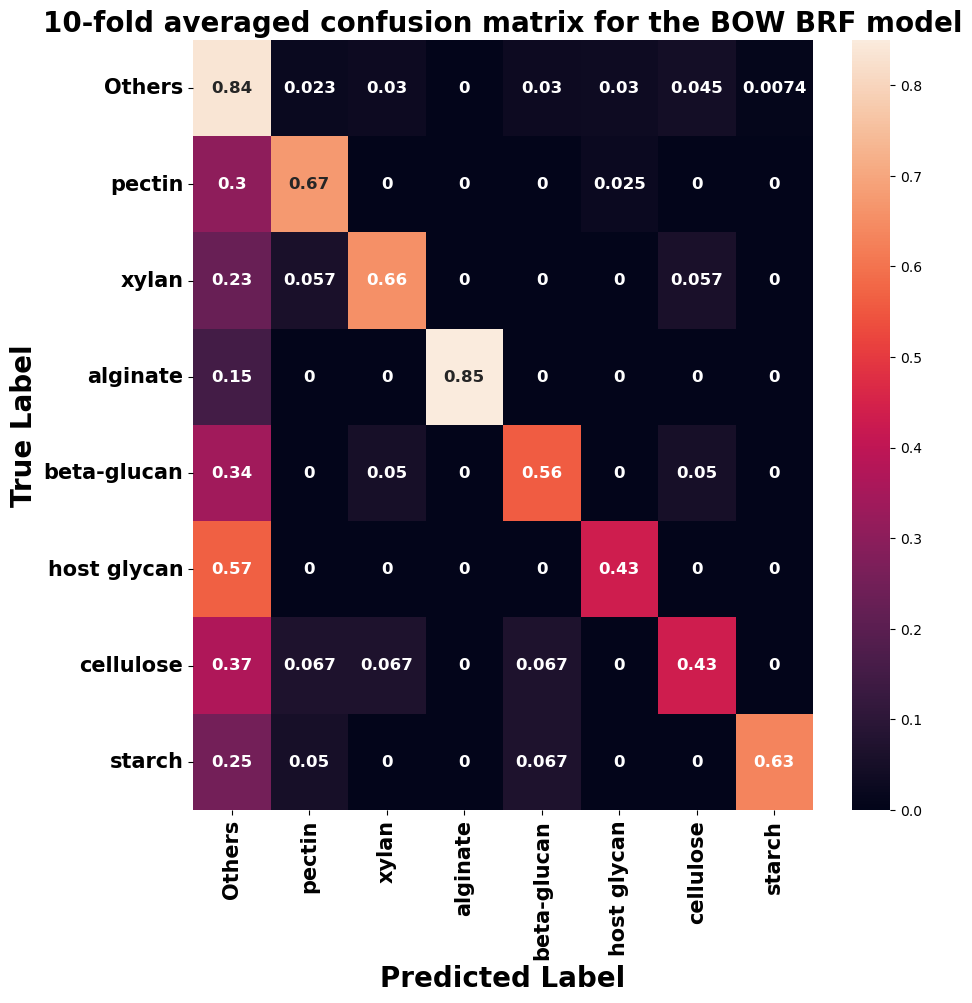

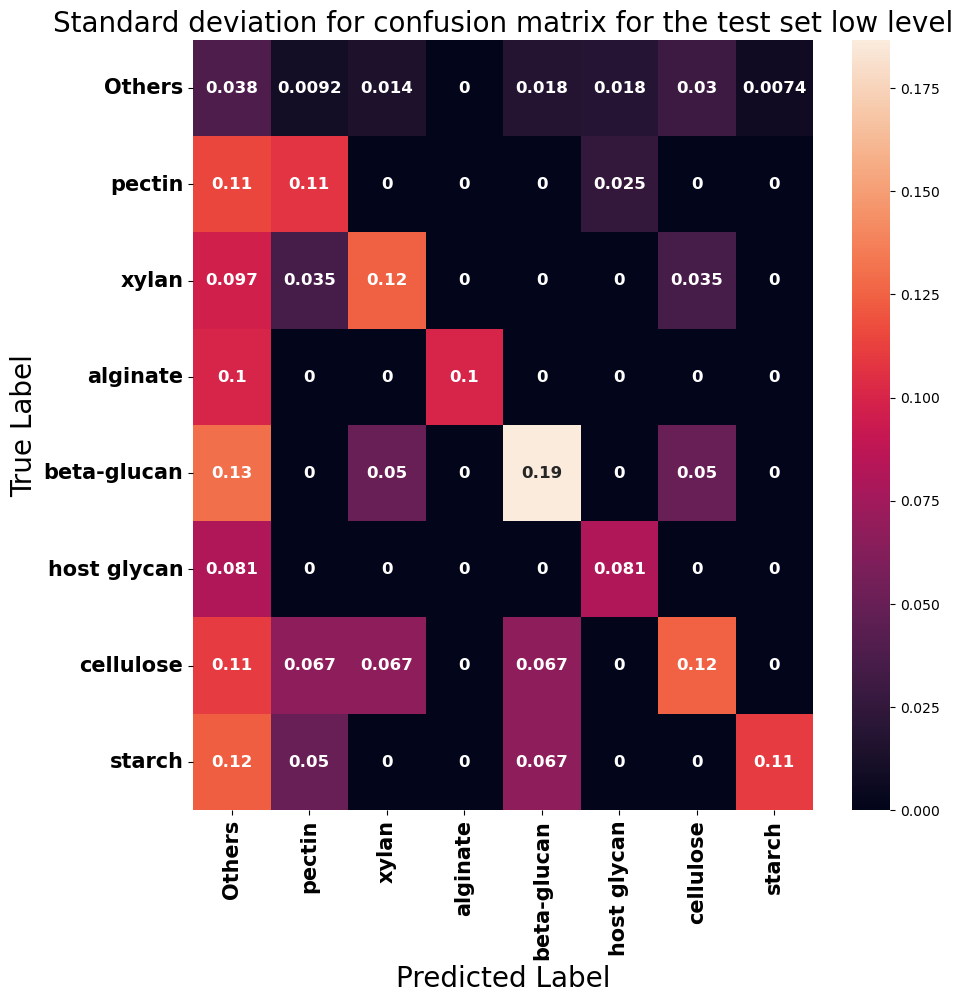

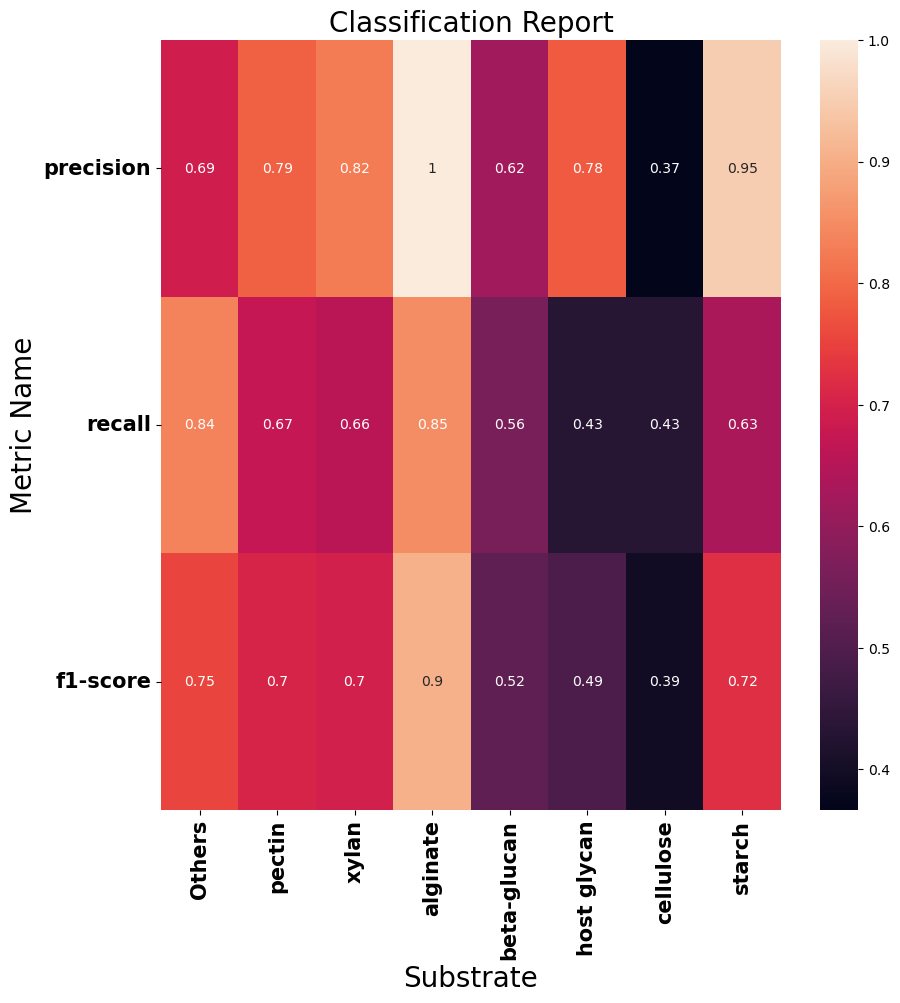

In [9]:
top_k=7
K = 5
known_unknown = True
featurizer = "transformer"

avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        


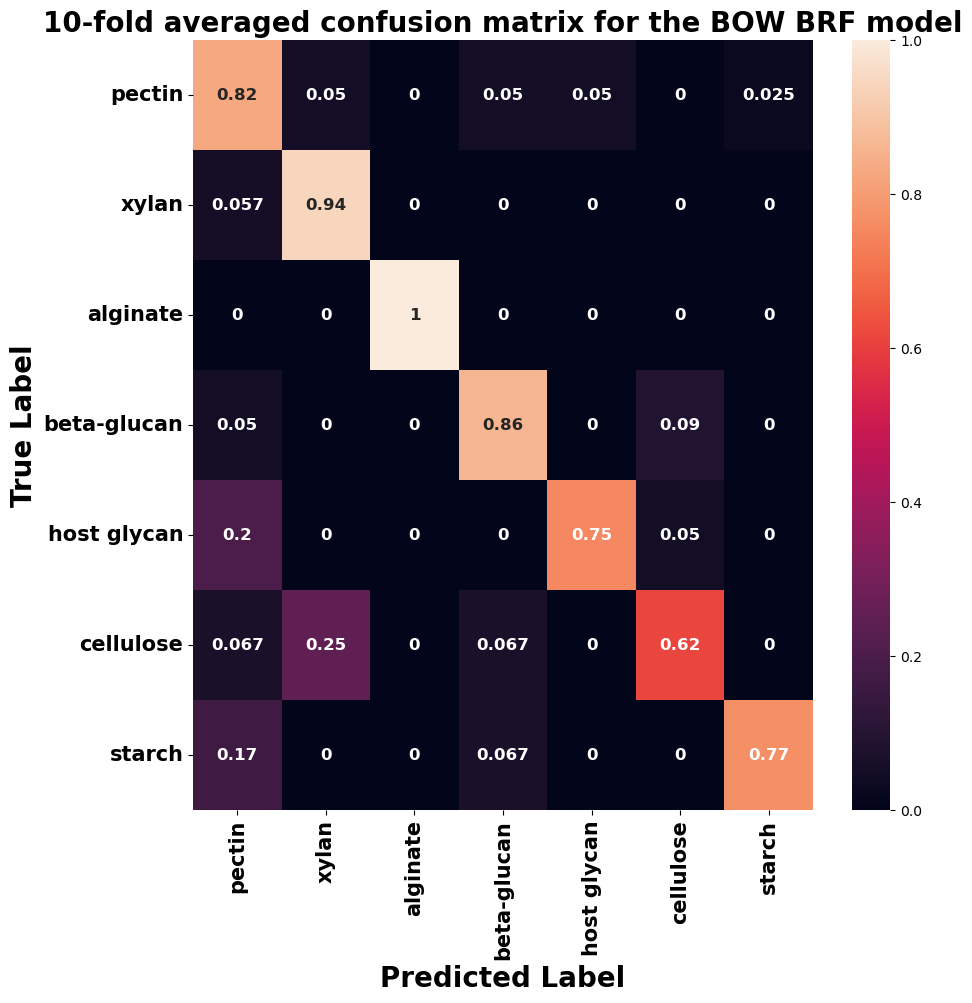

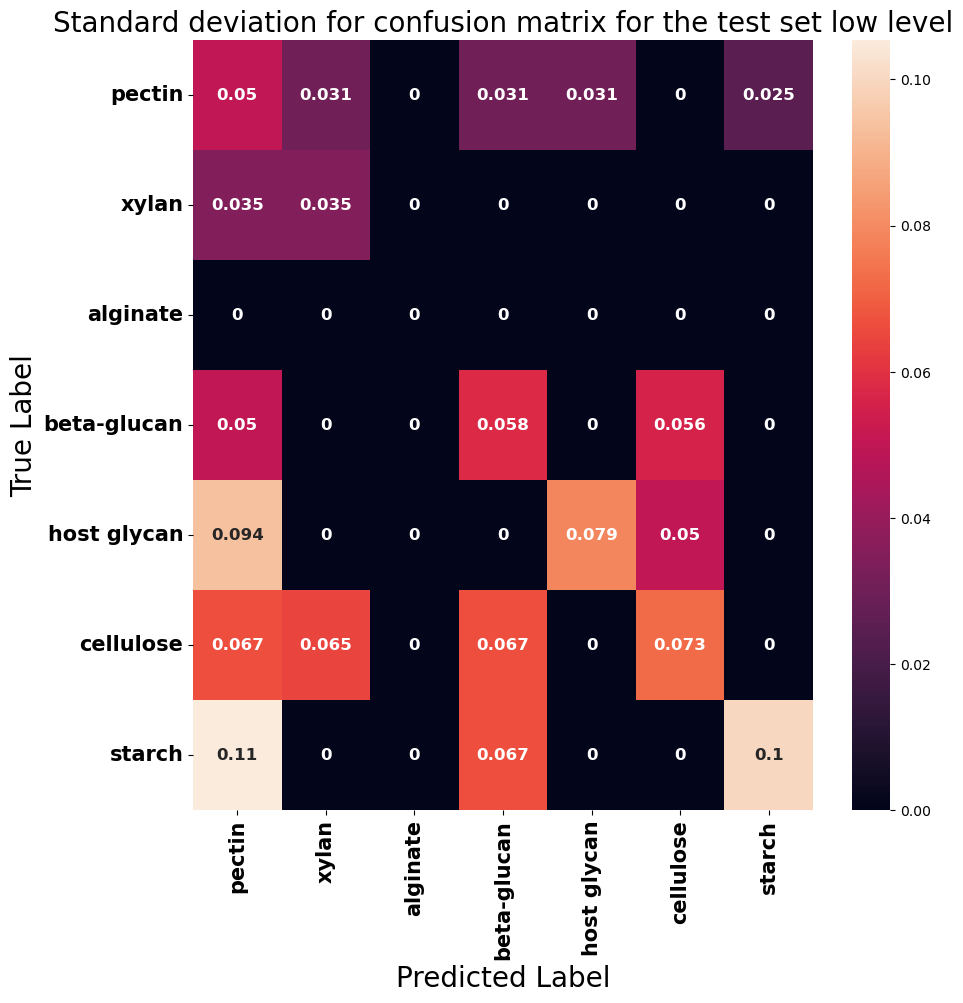

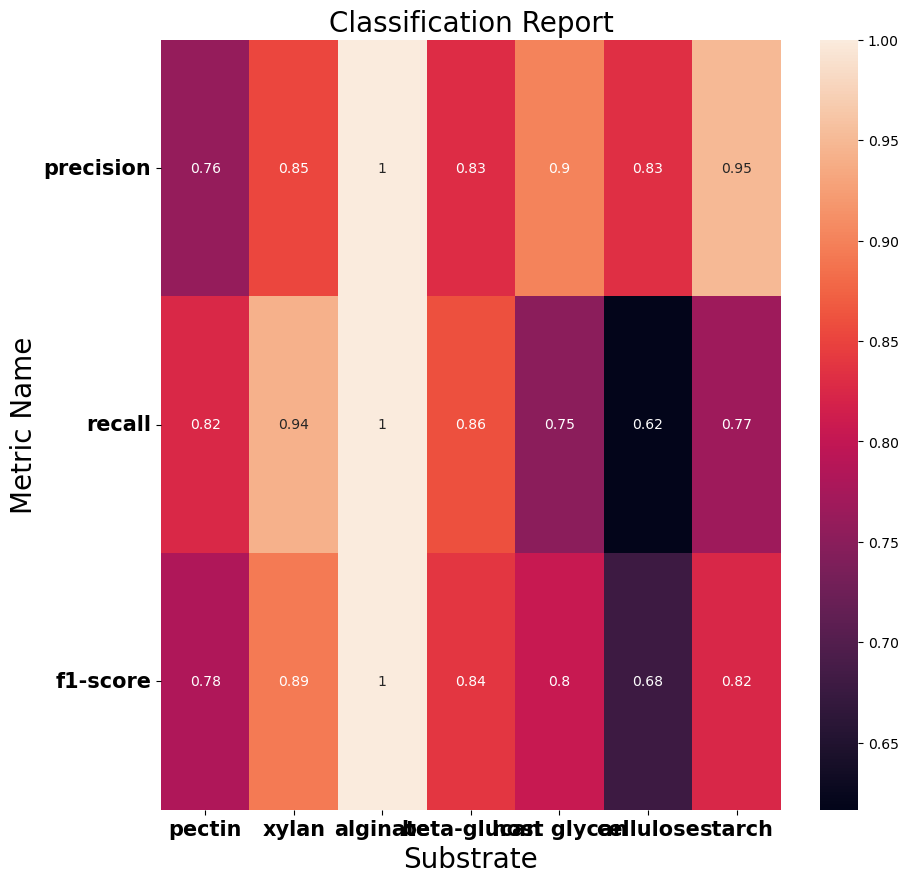

In [16]:
top_k=7
K = 5
known_unknown = False
featurizer = "just_attention"

avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        


In [10]:
print(avg_acc, avg_class_acc)

0.7176502732240438 0.6342729955229955


In [34]:
from tensorflow.keras.models import load_model
import joblib

# Load the saved model
model_dl = load_model('trained_model.h5')
le = joblib.load('label_encoder.pkl')

In [30]:
data_predict = pd.read_csv('Predict_data/output_cowrumen.csv')
data_predict

,cgc_id,sequence
0,MGYG000290000_2|CGC1,"2.A.115,null,1.A.30,null,2.A.51,2.A.51,GH36,GH..."
1,MGYG000290000_2|CGC2,"CBM50,GT2,GT4,null,1.B.57"
2,MGYG000290000_2|CGC3,"8.A.46,1.B.14,GH13_7,GH53"
3,MGYG000290000_2|CGC4,"9.B.146,null,2.A.103,GT28"
4,MGYG000290000_3|CGC1,"PL40|PL40,GH97,GH28,HTH_AraC,GerE,1.B.14"
...,...,...
50127,MGYG000295581_57|CGC1,"GT2,9.B.105"
50128,MGYG000295581_64|CGC1,"9.B.18,null,GT2"
50129,MGYG000295581_65|CGC1,"8.A.59,GH9|CBM3"
50130,MGYG000295581_197|CGC1,"3.A.1,null,GH13_11"


In [32]:
test_seqs = np.array([test_item.replace("|", ",").replace(",", " ") for test_item in data_predict["sequence"].values])
test_seqs2 = test_seqs[1:100]
test_seqs2.shape

(99,)

In [35]:
y_test_pred = model_dl.predict(test_seqs2, batch_size = 1, verbose = 0)
y_test_pred = y_test_pred.argmax(1)
y_test_pred = le.inverse_transform(y_test_pred.ravel())
y_test_pred

array(['pectin', 'starch', 'pectin', 'pectin', 'xylan', 'cellulose',
       'beta-glucan', 'pectin', 'pectin', 'pectin', 'pectin', 'pectin',
       'pectin', 'beta-glucan', 'pectin', 'xylan', 'pectin', 'starch',
       'pectin', 'beta-glucan', 'pectin', 'pectin', 'xylan',
       'beta-glucan', 'xylan', 'cellulose', 'pectin', 'pectin', 'pectin',
       'beta-glucan', 'cellulose', 'xylan', 'pectin', 'host glycan',
       'beta-glucan', 'pectin', 'cellulose', 'xylan', 'cellulose',
       'cellulose', 'pectin', 'beta-glucan', 'pectin', 'xylan', 'pectin',
       'host glycan', 'pectin', 'pectin', 'pectin', 'beta-glucan',
       'pectin', 'starch', 'starch', 'pectin', 'pectin', 'pectin',
       'beta-glucan', 'pectin', 'pectin', 'pectin', 'starch', 'pectin',
       'starch', 'pectin', 'host glycan', 'pectin', 'pectin',
       'beta-glucan', 'pectin', 'pectin', 'starch', 'beta-glucan',
       'pectin', 'starch', 'pectin', 'pectin', 'starch', 'starch',
       'alginate', 'xylan', 'beta-glucan'

In [44]:
y_test_pred2 = model_dl.predict(test_seqs2, batch_size = 1, verbose = 0)
y_test_pred2 = y_test_pred2.argmax(1)
y_test_pred2 = le.inverse_transform(y_test_pred2.ravel())
y_test_pred2

array(['pectin', 'starch', 'pectin', 'pectin', 'xylan', 'cellulose',
       'beta-glucan', 'pectin', 'pectin', 'pectin', 'pectin', 'pectin',
       'pectin', 'beta-glucan', 'pectin', 'xylan', 'pectin', 'starch',
       'pectin', 'beta-glucan', 'pectin', 'pectin', 'xylan',
       'beta-glucan', 'xylan', 'cellulose', 'pectin', 'pectin', 'pectin',
       'beta-glucan', 'cellulose', 'xylan', 'pectin', 'host glycan',
       'beta-glucan', 'pectin', 'cellulose', 'xylan', 'cellulose',
       'cellulose', 'pectin', 'beta-glucan', 'pectin', 'xylan', 'pectin',
       'host glycan', 'pectin', 'pectin', 'pectin', 'beta-glucan',
       'pectin', 'starch', 'starch', 'pectin', 'pectin', 'pectin',
       'beta-glucan', 'pectin', 'pectin', 'pectin', 'starch', 'pectin',
       'starch', 'pectin', 'host glycan', 'pectin', 'pectin',
       'beta-glucan', 'pectin', 'pectin', 'starch', 'beta-glucan',
       'pectin', 'starch', 'pectin', 'pectin', 'starch', 'starch',
       'alginate', 'xylan', 'beta-glucan'

## evaluation of different k

In [10]:
# og = ["lstm_with_attention", "just_attention", "vanilla_lstm", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg",
#                        "fasttext_cbow"]
og = ["just_attention"]

In [13]:
overall_catch = []
for top_k in tqdm(range(6,12)):
# for top_k in tqdm(range(2,12)):
    for featurizer in og:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
#         print(avg_acc, avg_class_acc)
        plt.close('all')
    

  0%|          | 0/6 [00:00<?, ?it/s]

Currently running for featurizer just_attention with 6 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

Currently running for featurizer just_attention with 7 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

Currently running for featurizer just_attention with 8 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

Currently running for featurizer just_attention with 9 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

Currently running for featurizer just_attention with 10 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

Currently running for featurizer just_attention with 11 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/com

In [14]:
#model_sg
overall_catch = pd.DataFrame(overall_catch)
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]
overall_catch.head(10)

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,6,just_attention,0.814167,0.777778,0.111184,0.121399,0.788135,0.777778,0.757227
1,7,just_attention,0.845221,0.821429,0.083569,0.084179,0.836190,0.821429,0.803685
2,8,just_attention,0.768713,0.746875,0.070533,0.043213,0.768810,0.746875,0.728069
3,9,just_attention,0.715263,0.681481,0.080647,0.081692,0.672037,0.681481,0.648924
4,10,just_attention,0.720779,0.693333,0.119988,0.129304,0.702833,0.693333,0.670675
5,11,just_attention,0.691107,0.635606,0.096774,0.113254,0.603333,0.635606,0.599329


In [17]:
overall_catch.to_csv('comparison_result.csv', index = False)
overall_catch = pd.read_csv('comparison_result.csv')

In [19]:
catch = []
for item in overall_catch["feature_method"]: 
    if item == "doc2vec_dm":
        catch.append("doc2vec_dbow")
    elif item == "doc2vec_dbow":
        catch.append("doc2vec_dm")
    else:
        catch.append(item)
overall_catch["feature_method"] = catch
keep_the_best = overall_catch.loc[overall_catch.groupby('num_substrates')['avg_classwise_acc'].idxmax()]
keep_the_best

,num_substrates,feature_method,avg_accuracy,avg_classwise_acc,std_err_avg_acc,std_err_avg_classwise_acc,avg_precision,avg_recall,avg_f1_score
0,6,just_attention,0.814167,0.777778,0.111184,0.121399,0.788135,0.777778,0.757227
1,7,just_attention,0.845221,0.821429,0.083569,0.084179,0.836190,0.821429,0.803685
2,8,just_attention,0.768713,0.746875,0.070533,0.043213,0.768810,0.746875,0.728069
3,9,just_attention,0.715263,0.681481,0.080647,0.081692,0.672037,0.681481,0.648924
4,10,just_attention,0.720779,0.693333,0.119988,0.129304,0.702833,0.693333,0.670675
5,11,just_attention,0.691107,0.635606,0.096774,0.113254,0.603333,0.635606,0.599329


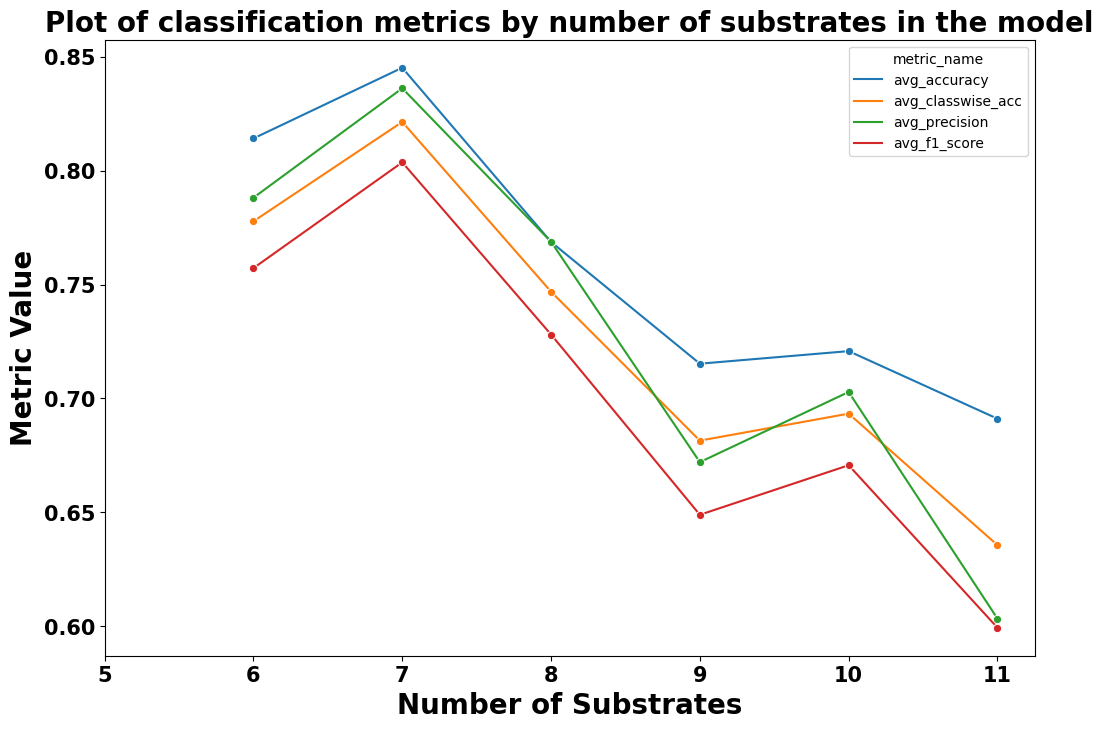

In [29]:
melt_best = keep_the_best.melt(id_vars=['num_substrates'], value_vars=['avg_accuracy', 'avg_classwise_acc', "avg_precision", "avg_f1_score"])
melt_best.columns = ['num_substrates', 'metric_name', 'metric_value']
plt.figure(figsize = (12,8))
sns.lineplot(data=melt_best, x="num_substrates", y="metric_value", hue="metric_name",  marker="o")
plt.title("Plot of classification metrics by number of substrates in the model", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Metric Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,12), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.savefig('Plot of classification metrics by number of substrates in the model.png')
plt.show()

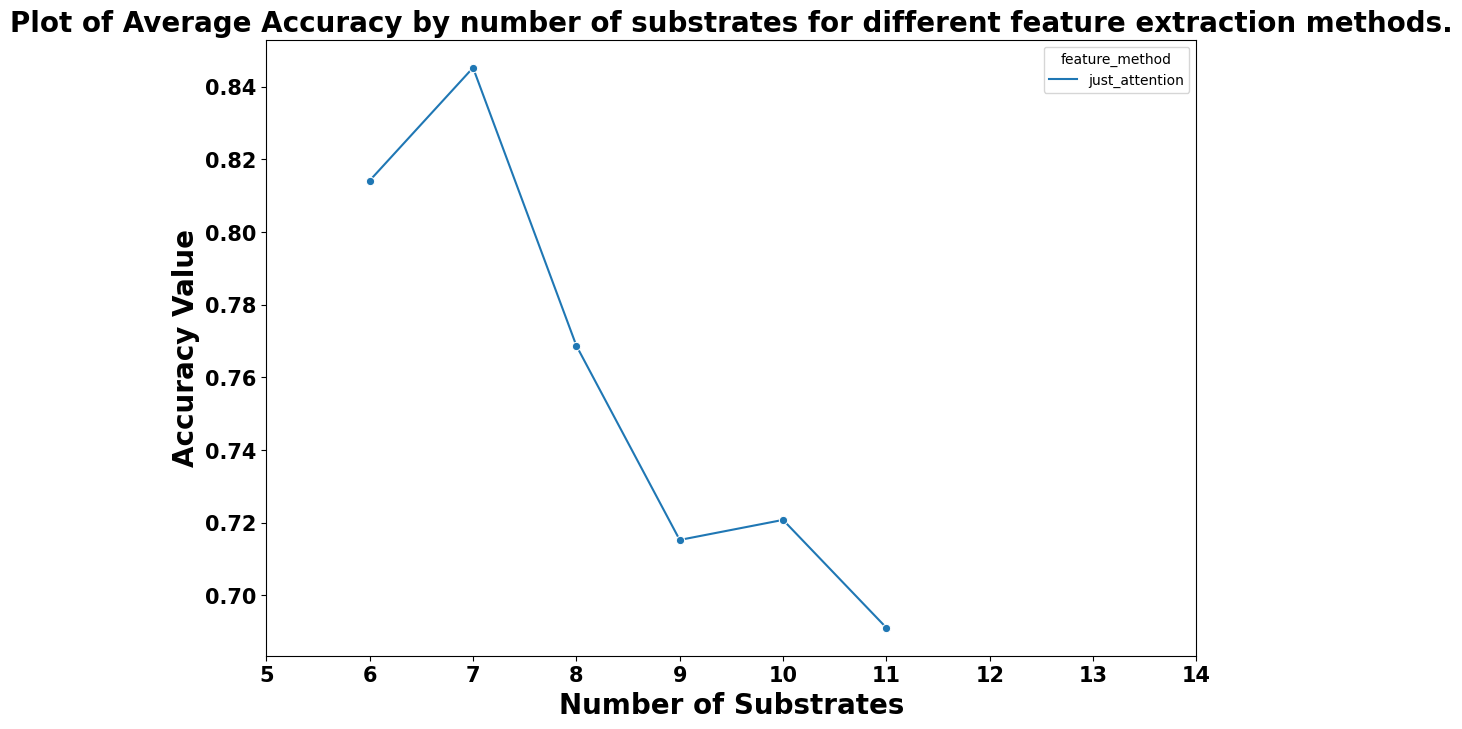

In [27]:
plt.figure(figsize = (12,8))
# filter_condn = [ "countvectorizer"]
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(5,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.savefig('Plot of Average Accuracy by number of substrates for different feature extraction methods.png')
plt.show()

## new

In [4]:
# library imports
import pandas as pd
import gensim
from Codes.Supervised_Trainer_tran import run_end_to_end
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.multiclass import OneVsRestClassifier
import plotly.express as px
import os

##########
#parameter
##########
# Define the range for top_k using tqdm
range_start = 2
range_end = 12
# model = ["transformer"]
# # model = ["lstm_with_attention", "just_attention", "transformer"]
# #full list mode all models
# model = ["lstm_with_attention", "just_attention", "transformer", "countvectorizer", "doc2vec_dbow", "doc2vec_dm", "word2vec_cbow", "word2vec_sg", "fasttext_sg", "fasttext_cbow"]            

############################################
#Import all csv file under Train_data folder
############################################

folder_path = "Train_data"
# List to hold DataFrames
dataframes = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

combined_data = pd.concat(dataframes, ignore_index=True)
combined_data.to_csv('combined_train_data.csv', index=False)
file_path = os.path.join('combined_train_data.csv')
data = pd.read_csv(file_path)



############################
#import word embedding model
############################
K = 5
known_unknown = False

# Define the base path for the models
base_path = "Embedding_Models"

# Use os.path.join to construct the file paths
model_dm_path = os.path.join(base_path, "doc2vec_dm")
model_dbow_path = os.path.join(base_path, "doc2vec_dbow")
model_cbow_path = os.path.join(base_path, "word2vec_cbow")
model_sg_path = os.path.join(base_path, "word2vec_sg")
model_fasttext_sg_path = os.path.join(base_path, "fasttext_sg")
model_fasttext_cbow_path = os.path.join(base_path, "fasttext_cbow")

# Load the models
model_dm = gensim.models.doc2vec.Doc2Vec.load(model_dm_path)
model_dbow = gensim.models.doc2vec.Doc2Vec.load(model_dbow_path)
model_cbow = gensim.models.word2vec.Word2Vec.load(model_cbow_path)
model_sg = gensim.models.word2vec.Word2Vec.load(model_sg_path)
model_fasttext_sg = gensim.models.word2vec.Word2Vec.load(model_fasttext_sg_path)
model_fasttext_cbow = gensim.models.word2vec.Word2Vec.load(model_fasttext_cbow_path)



In [2]:
# Define your list of featurizers
# featurizers = [
#     "countvectorizer",
#     "doc2vec_dbow",
#     "doc2vec_dm",
#     "word2vec_cbow",
#     "word2vec_sg",
#     "fasttext_sg",
#     "fasttext_cbow",
#     "lstm_with_attention",
#     "just_attention",
#     "vanilla_lstm",
#     "transformer"
# ]

featurizers = [
    'doc2vec_dbow',
    "transformer"
]

  0%|          | 0/1 [00:00<?, ?it/s]

Currently running for featurizer doc2vec_dbow with 7 number of classes.


/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and

[7, 'doc2vec_dbow', 0.790909090909091, 0.800374149659864, 0.039617131747121864, 0.03370976536270945, 0.8097278911564627, 0.8003741496598639, 0.7840502354788069]
Currently running for featurizer transformer with 7 number of classes.
[7, 'transformer', 0.8030303030303031, 0.8221768707482994, 0.05960694760050186, 0.07507486198538171, 0.8475736961451247, 0.8221768707482993, 0.8034126284546453]


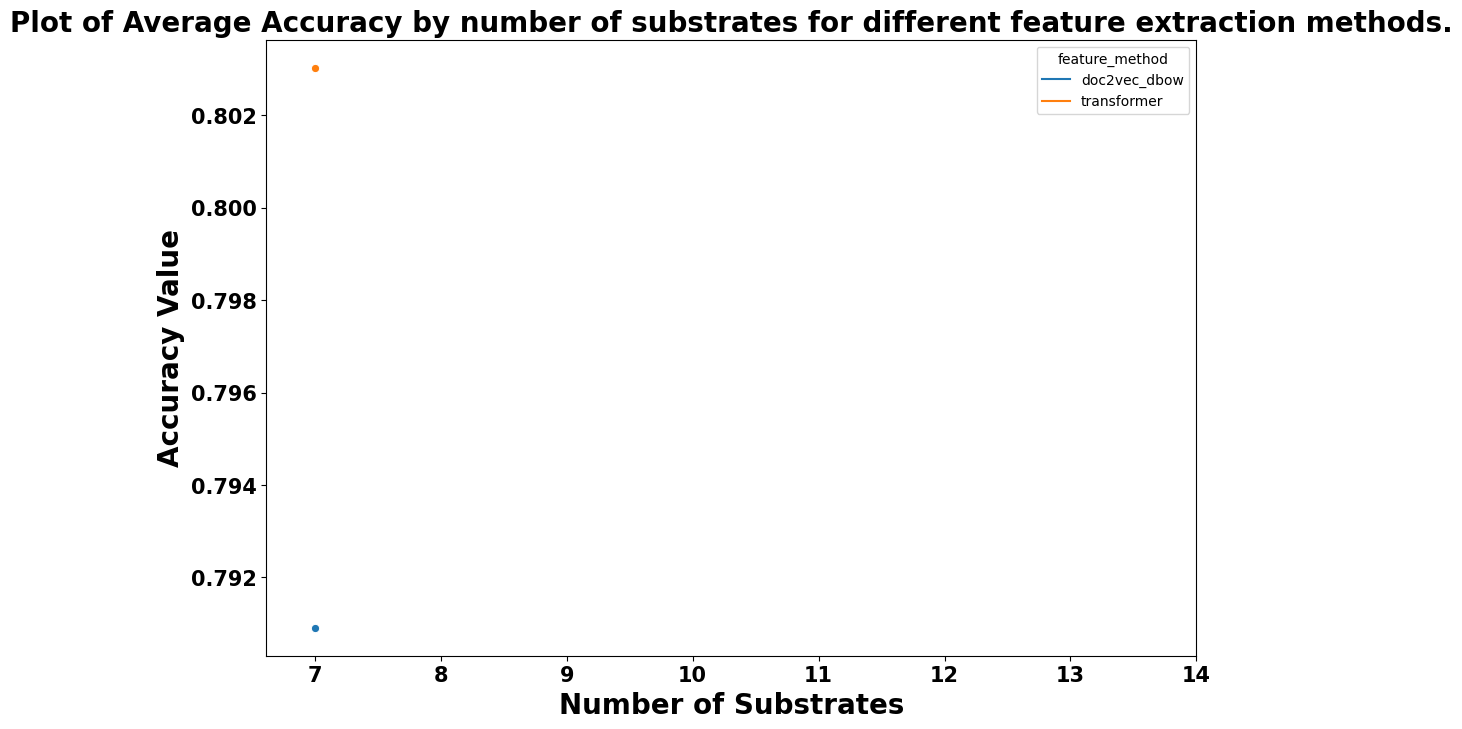

In [3]:


####################
#Training all models
####################

overall_catch = []
for top_k in tqdm(range(range_start,range_end)):
    for featurizer in featurizers:
        print("Currently running for featurizer "+ featurizer + " with " + str(top_k) + " number of classes.")
        if featurizer == "countvectorizer":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, None)
        elif featurizer == "doc2vec_dbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dbow)
        elif featurizer == "doc2vec_dm":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_dm)
        elif featurizer == "word2vec_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_cbow)            
        elif featurizer == "word2vec_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        elif featurizer == "fasttext_sg":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_sg)      
        elif featurizer == "fasttext_cbow":
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_fasttext_cbow)  
            
        elif featurizer == "lstm_with_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)
        
        elif featurizer == "just_attention": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "vanilla_lstm": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        elif featurizer == "transformer": 
            avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, overall_report,  model, params_best, fig, fig2, fig3 = run_end_to_end(top_k, data, featurizer, K, known_unknown, model_sg)        
        
        else:
            pass
        
        overall_catch.append([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        print([top_k, featurizer, avg_acc, avg_class_acc, std_err_avg_acc, std_err_avg_classwise_acc, 
                             overall_report["precision"], overall_report["recall"], overall_report["f1-score"]])
        plt.close('all')
        
#save all output to csv file
overall_catch = pd.DataFrame(overall_catch)
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]
overall_catch.to_csv('Comparison result of all models.csv', index = False)

#create a comparsion plot
plt.figure(figsize = (12,8))
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(7,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.savefig('Accuracy plot.png')


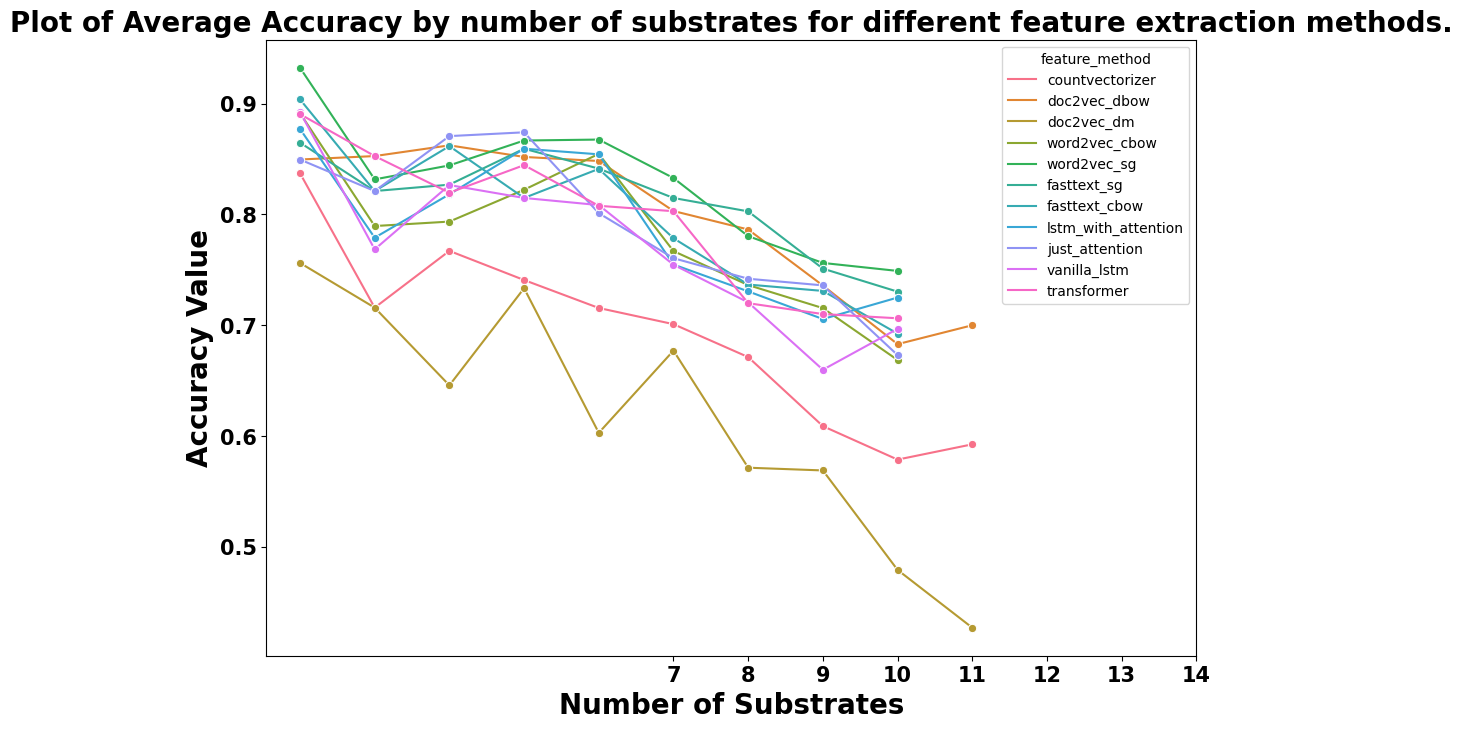

In [4]:
#save all output to csv file
overall_catch = pd.DataFrame(overall_catch)
overall_catch.columns = ["num_substrates", "feature_method", "avg_accuracy", "avg_classwise_acc",
                         "std_err_avg_acc", "std_err_avg_classwise_acc", "avg_precision", "avg_recall", "avg_f1_score"]
overall_catch.to_csv('Comparison result of all models.csv', index = False)

#create a comparsion plot
plt.figure(figsize = (12,8))
sns.lineplot(data=overall_catch,  x="num_substrates", y="avg_accuracy", hue="feature_method",  marker="o")
plt.title("Plot of Average Accuracy by number of substrates for different feature extraction methods.", fontsize = 20 ,weight = "bold")
plt.xlabel("Number of Substrates",  weight = "bold", fontsize = 20)
plt.ylabel("Accuracy Value", weight = "bold", fontsize = 20)
plt.xticks(range(7,15), weight = "bold", fontsize = 15)
plt.yticks(weight = "bold", fontsize = 15, rotation = 0)
plt.savefig('Accuracy plot.png')
